In [2]:
pip install brian2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 16.9 MB/s eta 0:00:00


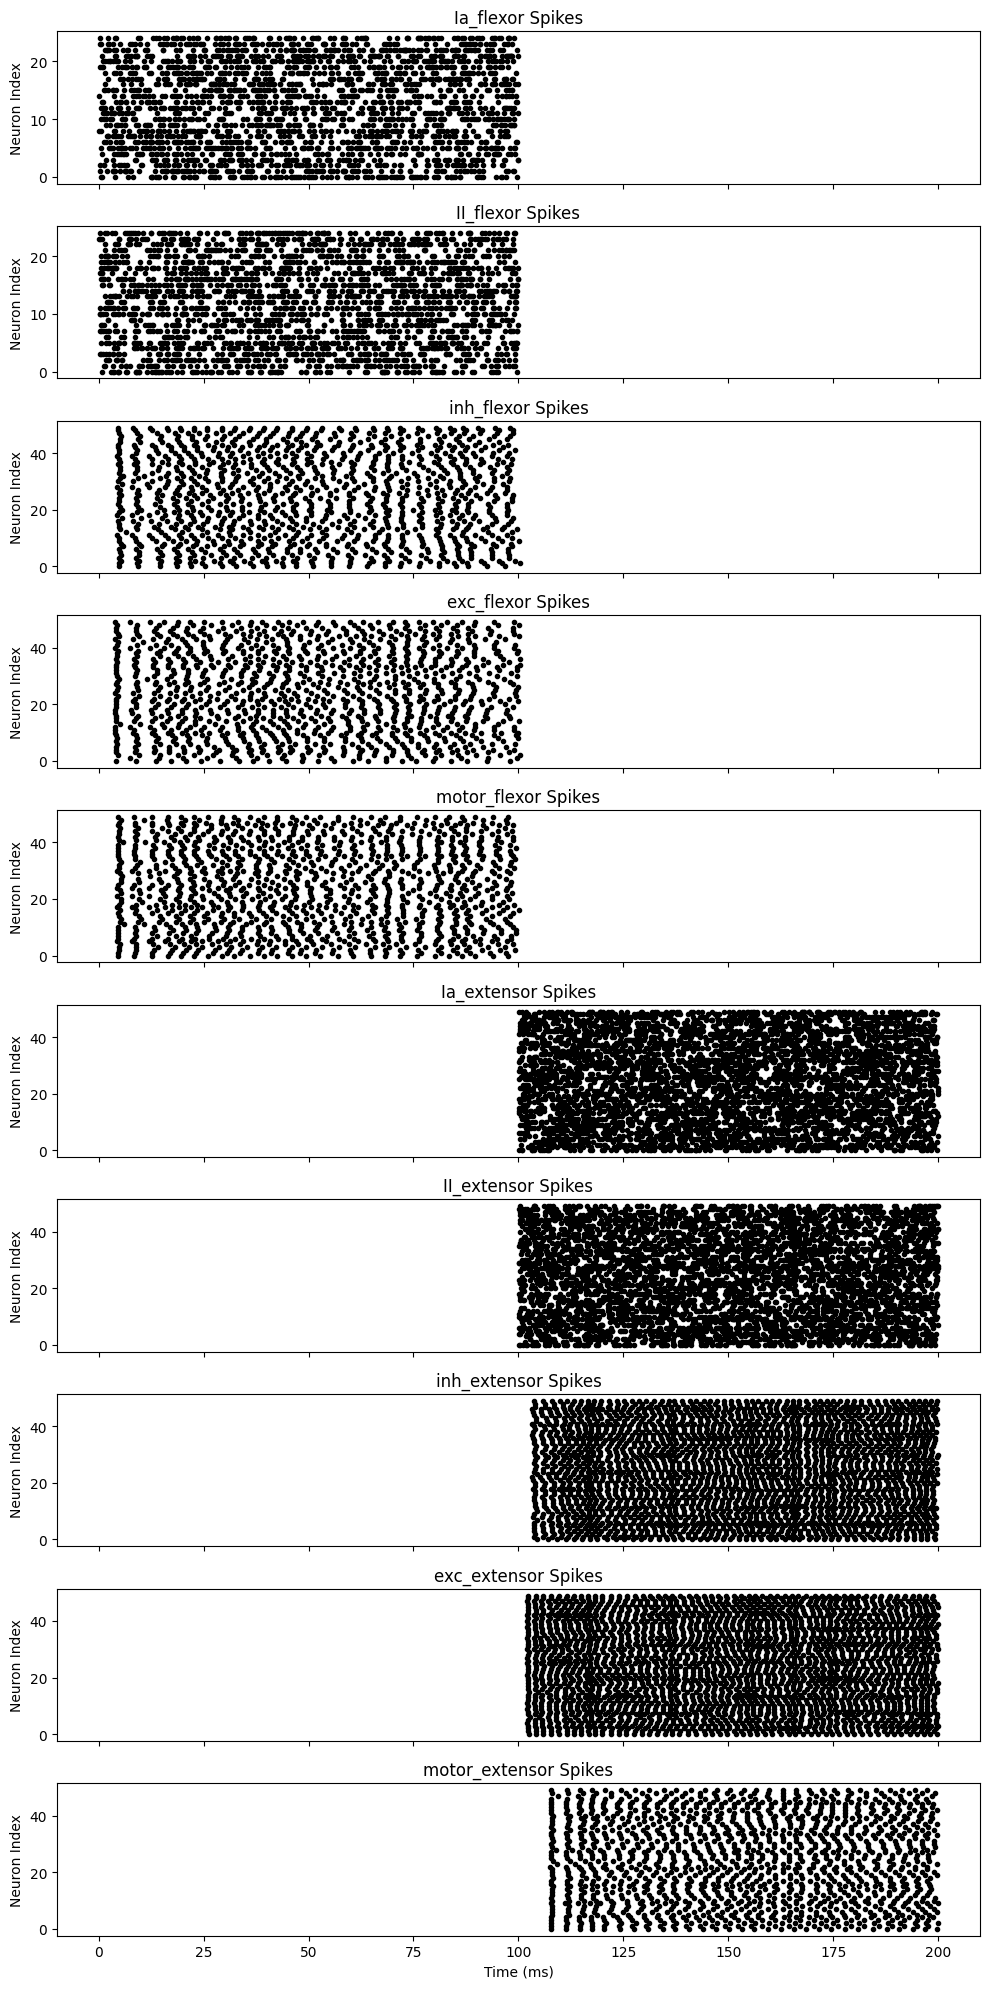

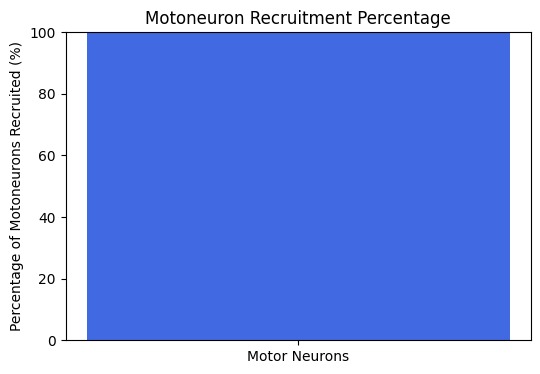

In [ ]:
from brian2 import *
import numpy as np
import matplotlib.pyplot as plt

# Set simulation parameters
defaultclock.dt = 0.025 * ms
cycle_time = 100 * ms

# Constants
El, gL, Cm = -70 * mV, 0.1 * mS, 1 * uF
E_ex, E_inh = 0 * mV, -75 * mV
tau_exc, tau_inh = 0.5 * ms, 3 * ms

# Neuron model (Leaky Integrate-and-Fire)
eqs = '''
dv/dt = (gL*(El - v) + Isyn)/ Cm : volt
Isyn = gi * (E_inh - v) + ge * (E_ex - v) : amp
ge : siemens
gi : siemens
'''

# Neuron populations
n = {"Ia": 50, "II": 50, "inh": 50, "exc": 50, "motor": 50}
n_tot = sum(list(n.values()))

neurons = NeuronGroup(n_tot * 2, eqs, threshold="v > -50*mV", reset="v = El", method="exact")
neurons.v = El  # Set initial voltage

# Dynamic neuron group mapping
def get_indices(start, sizes):
    indices = {}
    current_index = start
    for k, v in sizes.items():
        indices[k] = slice(current_index, current_index + v)
        current_index += v
    return indices

neurons_type = get_indices(0, {k + "_flexor": v for k, v in n.items()} | {k + "_extensor": v for k, v in n.items()})

# Function to select a fraction of neurons
def select_fraction(neuron_group, fraction):
    start, stop = neuron_group.start, neuron_group.stop
    return slice(start, start + int(fraction * (stop - start)))

# Select 50% of neurons for Poisson input
new_sli_II_flexor = select_fraction(neurons_type["II_flexor"], 0.5)
new_sli_Ia_flexor = select_fraction(neurons_type["Ia_flexor"], 0.5)

# Create Poisson inputs for selected neurons
poisson_inputs = [
    PoissonInput(neurons[new_sli_II_flexor], "v", N=10, rate=1/(10*ms), weight=100 * mV),
    PoissonInput(neurons[new_sli_Ia_flexor], "v", N=10, rate=1/(10*ms), weight=100 * mV),
    PoissonInput(neurons[neurons_type["II_extensor"]], "v", N=10, rate=1/(10*ms), weight=100 * mV),
    PoissonInput(neurons[neurons_type["Ia_extensor"]], "v", N=10, rate=1/(10*ms), weight=100 * mV)
]

# Synapse model templates
synapse_eqs = {
    "exc": """
        dx/dt = -x / tau_exc : siemens (clock-driven)
        ge_post = x : siemens  (summed)
        w: siemens # Synaptic weight
    """,
    "inh": """
        dg/dt = (x - g) / tau_inh : siemens (clock-driven)
        dx/dt = -x / tau_inh : siemens (clock-driven)
        gi_post = g : siemens  (summed)
        w: siemens # Synaptic weight
    """
}

# Function to create synapses
def create_synapse(pre, post, syn_type, p=1.0):
    syn = Synapses(neurons[neurons_type[pre]], neurons[neurons_type[post]], method='exact',
                   model=synapse_eqs[syn_type], on_pre=' x += w')
    syn.connect(p=p)
    syn.w = '10*uS'
    return syn

# Synapse connections
synapses = {name: create_synapse(*name.split("_to_"), "exc" if "exc" in name or "Ia" in name or "II" in name else "inh", p=0.9)
            for name in [
                "Ia_extensor_to_motor_extensor", "Ia_extensor_to_inh_extensor", "II_extensor_to_exc_extensor",
                "II_extensor_to_inh_extensor", "exc_extensor_to_motor_extensor", "inh_extensor_to_motor_flexor",
                "Ia_flexor_to_motor_flexor", "Ia_flexor_to_inh_flexor", "II_flexor_to_exc_flexor", "II_flexor_to_inh_flexor",
                "exc_flexor_to_motor_flexor", "inh_flexor_to_motor_extensor", "inh_flexor_to_inh_extensor", "inh_extensor_to_inh_flexor"
            ]}

# Network construction
net = Network([neurons] + poisson_inputs[0:2] + list(synapses.values()))

# Monitoring
spikes = {name: SpikeMonitor(neurons[neurons_type[name]]) for name in neurons_type}
net.add(spikes.values())

# Run the simulation
net.run(cycle_time)
net.remove(poisson_inputs[0])
net.remove(poisson_inputs[1])
net.add(poisson_inputs[2])
net.add(poisson_inputs[3])
net.run(cycle_time)


# Plot spikes
fig, axs = plt.subplots(len(spikes), 1, figsize=(10, 20), sharex=True)
for ax, (name, spike_monitor) in zip(axs, spikes.items()):
    ax.plot(spike_monitor.t / ms, spike_monitor.i, 'k.')
    ax.set(title=f'{name} Spikes', ylabel='Neuron Index')
axs[-1].set_xlabel('Time (ms)')
plt.tight_layout()
plt.show()



10. ms


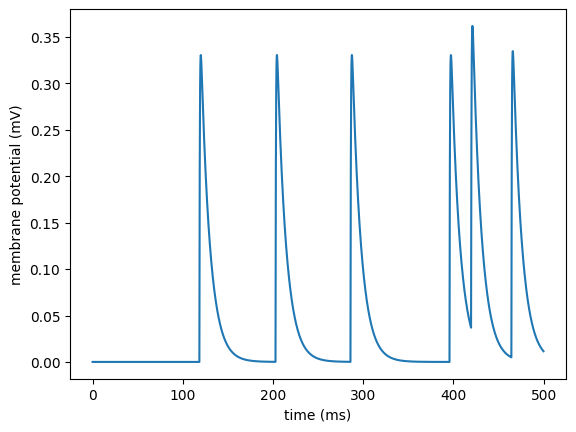

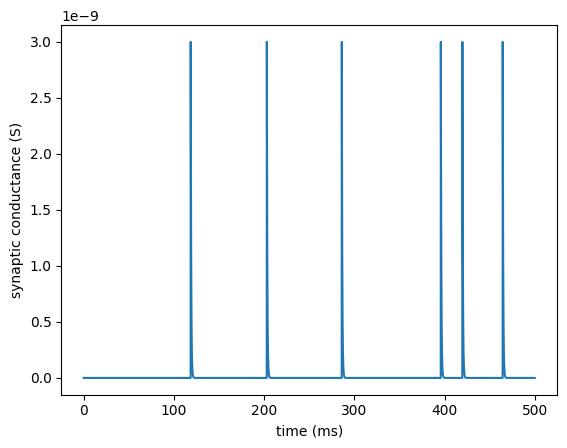

In [13]:
from brian2 import *

# Parameters
gL = 30 * nS
C= 0.3 * nF
taum = C / gL
print(taum)
EL = -70 * mV
Vcut = -55*mV
defaultclock.dt = 0.1 * ms
Ee=0*mV
tauw=0.5*ms

eqs = """
dvm/dt = (gL*(EL - vm)  + w*(Ee- vm))/C : volt
w: siemens
"""
eqs_synapse="""
dg/dt = - g/tauw : siemens
w_post=g: siemens (summed)

"""
neuron = NeuronGroup(1, model=eqs, threshold='vm>Vcut',
                     reset="vm=EL", method='euler')
stimulator = PoissonGroup(1,rates=1/(200*ms))
synapse=Synapses(stimulator,neuron,method='exact', model=eqs_synapse ,on_pre='g+=3*nS')
synapse.connect(p=1)
neuron.vm = EL
trace = StateMonitor(neuron, ['vm', 'w'], record=0)
spikes = SpikeMonitor(neuron)

run(500 * ms)


plot(trace.t / ms, (trace[0].vm-EL) / mV)
xlabel('time (ms)')
ylabel('membrane potential (mV)')
show()
plot(trace.t / ms, trace[0].w / siemens)
xlabel('time (ms)')
ylabel('synaptic conductance (S)')
show()


WARNING    <ipython-input-38-6518d47cd4b1>:88: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  recruited_motoneuron = sum(len(spikes) > 0 for spikes in moto_spike_dict.values()) / neuron_pop['motor']
 [py.warnings]
  recruited_motoneuron = sum(len(spikes) > 0 for spikes in moto_spike_dict.values()) / neuron_pop['motor']



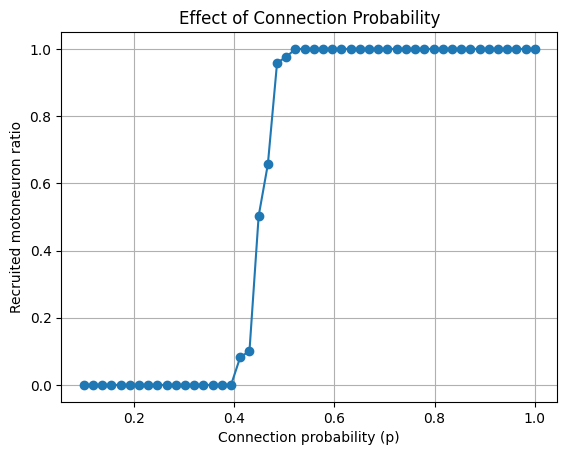

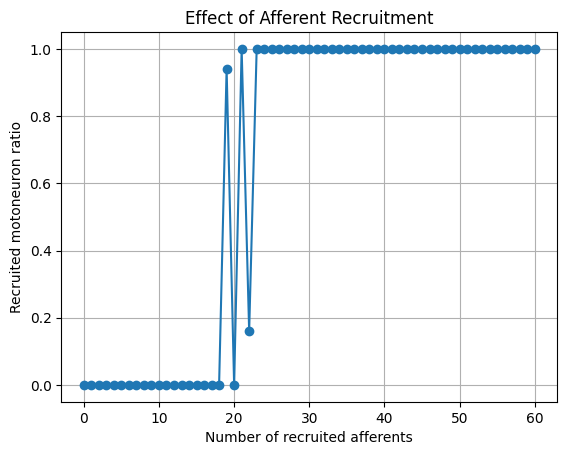

In [38]:
import matplotlib.pyplot as plt
from brian2 import *

import matplotlib.pyplot as plt
from brian2 import *

def run_neural_simulations(neuron_pop, dt_run, T, w_run=3*nS, p=0.9, Eleaky=-70*mV,
    gL=10*nS, Cm=0.3*nF, E_ex=0*mV, E_inh=-75*mV, tau_exc=0.5*ms, tau_inh=2*ms,
    threshold_v=-55*mV, ees_freq=0*hertz, aff_recruited=0, T_refr=2*ms):

    np.random.seed(42)
    seed(42)
    defaultclock.dt = dt_run

    # Ia group
    ia_eq = '''
        is_ees = (i < aff_recruited): boolean
        rate = 10*hertz + ees_freq * int(is_ees) : Hz
    '''
    Ia = NeuronGroup(neuron_pop["Ia"], ia_eq, threshold='rand() < rate*dt',
                     reset='v=Eleaky', refractory=T_refr, method='euler')

    # II group
    ii_eq = '''
        is_ees = (i < aff_recruited): boolean
        rate = 20*hertz + ees_freq * int(is_ees) : Hz
    '''
    II = NeuronGroup(neuron_pop["II"], ii_eq, threshold='rand() < rate*dt',
                     reset='v=Eleaky', refractory=T_refr, method='euler')

    # Main neuron dynamics
    eqs = '''
    dv/dt = (gL*(Eleaky - v) + Isyn) / Cm : volt
    Isyn = (ge + ge2) * (E_ex - v) : amp
    ge : siemens
    ge2 : siemens
    '''
    Excitatory = NeuronGroup(neuron_pop["exc"], eqs, threshold='v > threshold_v',
                             reset='v = Eleaky', method='exact')
    Excitatory.v = Eleaky

    Motoneuron = NeuronGroup(neuron_pop["motor"], eqs, threshold='v > threshold_v',
                             reset='v = Eleaky', method='exact')
    Motoneuron.v = Eleaky

    # Synapses with proper w_ declaration
    noise_level = 0.2

    II_Ex = Synapses(II, Excitatory,
        model='''dx/dt = -x / tau_exc : siemens (clock-driven)
                 ge_post = x : siemens (summed)
                 w : siemens''',
        on_pre='x += w', method='exact')
    II_Ex.connect(p=p)
    II_Ex.w = np.clip(w_run + noise_level * w_run * randn(len(II_Ex.w)), 0*nS, np.inf*nS)

    Ia_Motoneuron = Synapses(Ia, Motoneuron,
        model='''dy/dt = -y / tau_exc : siemens (clock-driven)
                 ge_post = y : siemens (summed)
                 w : siemens''',
        on_pre='y += w', method='exact')
    Ia_Motoneuron.connect(p=p)
    Ia_Motoneuron.w = np.clip(w_run + noise_level * w_run * randn(len(Ia_Motoneuron.w)), 0*nS, np.inf*nS)
    Ex_Motoneuron = Synapses(Excitatory, Motoneuron,
        model='''dz/dt = -z / tau_exc : siemens (clock-driven)
                 ge2_post = z : siemens (summed)
                 w : siemens''',
        on_pre='z += w', method='exact')
    Ex_Motoneuron.connect(p=p)
    Ex_Motoneuron.w=w_run
    #Ex_Motoneuron.w = np.clip(w_run + noise_level * w_run * randn(len(Ex_Motoneuron.w)), 0*nS,  np.inf*nS)

    # Monitors
    mon_motor = SpikeMonitor(Motoneuron)
    mon_Ia = SpikeMonitor(Ia)
    mon_II = SpikeMonitor(II)

    # Network
    net = Network()
    net.add([
        Ia, II, Excitatory, Motoneuron,
        II_Ex, Ia_Motoneuron, Ex_Motoneuron,
        mon_Ia, mon_II, mon_motor
    ])
    net.run(T)

    moto_spike_dict = mon_motor.spike_trains()
    recruited_motoneuron = sum(len(spikes) > 0 for spikes in moto_spike_dict.values()) / neuron_pop['motor']

    return [{
        "Ia": mon_Ia.spike_trains(),
        "II": mon_II.spike_trains(),
        "MN": moto_spike_dict
    }], recruited_motoneuron



# Simulation settings
T = 40*ms
dt_run = 0.1*ms
neuron_pop = {"Ia": 60, "II": 60, "exc": 196, "motor": 169}

# 1. Vary connection probability
proba = np.linspace(0.1, 1.0, 50)
recruited_by_proba = []
for p_ in proba:
    _, ratio = run_neural_simulations(neuron_pop, dt_run, T, w_run=3*nS, p=p_,
                                      ees_freq=50*Hz, aff_recruited=60)
    recruited_by_proba.append(ratio)

plt.figure()
plt.plot(proba, recruited_by_proba, 'o-')
plt.xlabel('Connection probability (p)')
plt.ylabel('Recruited motoneuron ratio')
plt.title('Effect of Connection Probability')
plt.grid()

# 2. Vary afferent recruitment
n_afferent = np.linspace(0, 60, 61)
recruited_by_afferent = []
for n in n_afferent:
    _, ratio = run_neural_simulations(neuron_pop, dt_run, T, w_run=3*nS, p=0.9,
                                      ees_freq=50*Hz, aff_recruited=n)
    recruited_by_afferent.append(ratio)

plt.figure()
plt.plot(n_afferent, recruited_by_afferent, 'o-')
plt.xlabel('Number of recruited afferents')
plt.ylabel('Recruited motoneuron ratio')
plt.title('Effect of Afferent Recruitment')
plt.grid()
plt.show()
